# Bird Species Classification

In [190]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import pandas as pd
import random
from tqdm import tqdm
from joblib import Parallel, delayed
import joblib
from typing import Dict, Tuple, Generator
import contextlib
from sklearn import metrics

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

# Defining a context manager to track the execution of parallel jobs

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

#### Exporing the Dataset

- The dataset for this project is taken from kaggle at https://www.kaggle.com/datasets/gpiosenka/100-bird-species?resource=download
- It consists of 62388 distinct images of 400 different bird species, with an average of approximately 156 images per bird.
- The dataset is split into training, validation and test, with size 58388, 2000, 2000 respectively.
- I'll write a function to select a random file from the training set and display it.

In [2]:
# Define path to my data on my local system

path_to_data = 'C:/Users/Tom/Documents/GitHub/Bird Data'

In [128]:
def display_random_image_in_data_set(path: str) -> np.ndarray:
    """
    Function to display any random image from the data set.

    Args:
        path: Path to top level directory
    """

    # Selecting image

    top_level_directory_contents = os.listdir(path)
    species_choice = random.choice(top_level_directory_contents)
    path_to_species = os.path.join(path, species_choice)
    print(f"Displaying random bird of species {species_choice}")

    image_choice = os.path.join(path_to_species, random.choice(os.listdir(path_to_species)))
    # Displaying image

    im = PIL.Image.open(image_choice)
    display(im)

    return np.array(im)

Displaying random bird of species MALACHITE KINGFISHER


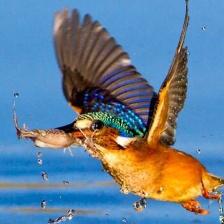

In [129]:
display_random_image_in_data_set(os.path.join(path_to_data, 'train'));

Displaying random bird of species AVADAVAT


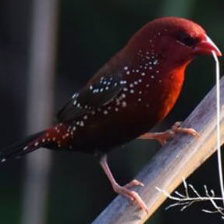

In [130]:
display_random_image_in_data_set(os.path.join(path_to_data, 'train'));

Displaying random bird of species BARN OWL


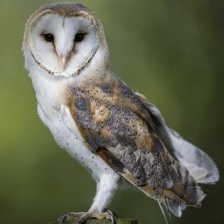

In [131]:
display_random_image_in_data_set(os.path.join(path_to_data, 'test'));

Displaying random bird of species GOLDEN EAGLE


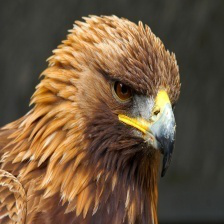

In [132]:
display_random_image_in_data_set(os.path.join(path_to_data, 'valid'));

- We see we have various high-quality images of different species of birds in the training, validation and test sets.
- Let's load the training set and have look at the size of a few images to see what we're working with.
- As the dataset is quite large, we'll use joblib to load in parallel.
- We could use the keras.utils.image_dataset_from_directory to load the dataset directly from disk for training, but as I'm running on a 64gb machine, we should have enough memory to load the entire dataset, which should be faster when fitting.

In [7]:
def load_images_in_directory(path: str, species: str) -> Dict[str, np.ndarray]:
    """
    Loads all the images in a directory and returns a dictionary of path:np.array

    Args:
        path: Directory containing images to be loaded.

    Returns:
        dict: Dictionary with key value pairs path:image
    """

    # Joining path and instantiating empty dict

    path = os.path.join(path, species)
    image_data = {}
    
    # Iterating through images, loading, converting to numpy array and adding to the dict

    for image in [os.path.join(path, x) for x in os.listdir(path)]:
        img = PIL.Image.open(image)
        img.load()
        data = np.asarray(img, dtype="float32")
        image_data[image] = data

    return image_data

def load_images(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function to load all images in the dataset to memory

    Args:
        path: Path to directory
    
    Returns:
        Tuple of features and labels
    """

    # Iterating through directories in parallel and loading images

    top_level_directory_contents = os.listdir(path)

    with tqdm_joblib(tqdm(desc="Loading Images", total=len(top_level_directory_contents))) as progress_bar:
        image_data = Parallel(n_jobs=-1)(delayed(load_images_in_directory)(path, x) for x in top_level_directory_contents)

    # Merging dictionaries

    image_data = {k: v for d in image_data for k, v in d.items()}
        
    # Formatting dataset
    
    images = []
    labels = []

    for key, item in image_data.items():
        labels.append(key.split('\\')[-2])
        images.append(np.expand_dims(item, 0))

    images = np.concatenate(images, axis=0)

    label_mapper = dict(zip(np.unique(labels), np.arange(len(np.unique(labels)))))

    return images, np.array([label_mapper[x] for x in labels])

In [8]:
X_train, y_train = load_images(os.path.join(path_to_data, 'train'))

Loading Images: 100%|██████████| 400/400 [01:11<00:00,  5.58it/s]


In [13]:
X_val, y_val = load_images(os.path.join(path_to_data, 'valid'))

Loading Images: 100%|██████████| 400/400 [00:03<00:00, 113.49it/s]


In [10]:
print(f"Size of training data set: {X_train.shape} \nSize of training labels {y_train.shape}")

Size of training data set: (58388, 224, 224, 3) 
Size of training labels (58388,)


- We can see from the above that we have successfully loaded the images and compiled into a training dataset
- X_train is a numpy array of 58388 images of size 244x244 with 3 colour channels
- y_train is a numpy array of integers expressed as floats of size 58388, with a unique integer corresponding to the bird species
- Let's write a function to create our dataset generators and a function to plot our model training history.

In [59]:
def create_training_and_validation_datasets(
    X_train: np.ndarray, 
    y_train: np.ndarray, 
    X_val: np.ndarray,
    y_val: np.ndarray,
    batch_size: int
) -> Tuple[Generator, Generator, int, int, int]:
    """
    Function to create dataset generators, returning image height, image width and the number of classes.

    Args:
        X_train: Training images
        y_train: Training labels
        X_val: Validation images
        y_val: Validation labels
        batch_size: Batch size
    Returns:
        Tuple of training and validation generators, image width and height, and number of classes.
    """

    image_data_generator = ImageDataGenerator()
    train_ds = image_data_generator.flow(X_train, y_train, batch_size=batch_size)
    valid_ds = image_data_generator.flow(X_val, y_val, batch_size=batch_size)

    for x in train_ds:
        X_train_shape = x[0].shape
        image_width = X_train_shape[1]
        image_height = X_train_shape[2]
        break

    num_classes = len(np.unique(train_ds.y))

    return train_ds, valid_ds, image_height, image_width, num_classes

def plot_model_training_history(history: keras.callbacks.History) -> None:
    """
    Function to plot the training history of the model.

    Args:
    history: Model fit history
    """

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)

    fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

    ax[0].set_title('Accuracy')
    ax[0].plot(epochs, accuracy, label='Training Set', linewidth=3)
    ax[0].plot(epochs, val_accuracy, label='Validation Set', linewidth=3)
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title('Loss')
    ax[1].plot(epochs, loss, label='Training Set', linewidth=3)
    ax[1].plot(epochs, val_loss, label='Validation Set', linewidth=3)
    ax[1].legend()
    ax[1].grid()

In [46]:
train_ds, valid_ds, img_height, img_width, num_classes = create_training_and_validation_datasets(X_train, y_train, X_val, y_val, 256)

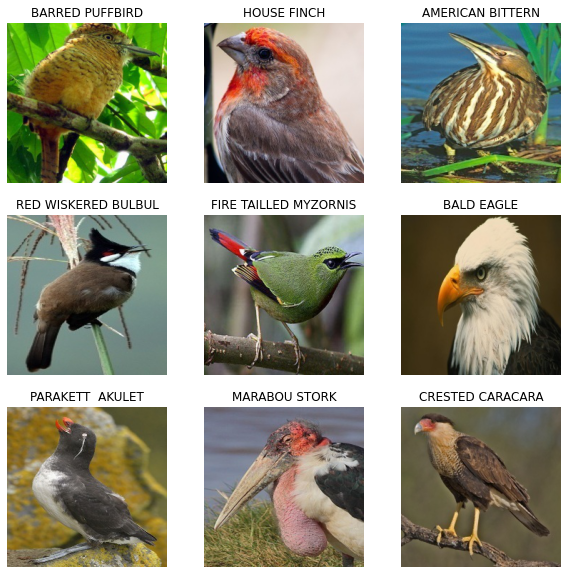

In [56]:
#### Displaying a few images from the dataset

class_names = os.listdir(os.path.join(path_to_data, 'train'))

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  break

In [61]:
model = Sequential([
  layers.Resizing(112, 112, input_shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
history = model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=20,
)

Epoch 1/20
229/229 [==============================] - 32s 136ms/step - loss: 5.4539 - accuracy: 0.0305 - val_loss: 4.3516 - val_accuracy: 0.1345
Epoch 2/20
229/229 [==============================] - 28s 124ms/step - loss: 3.8097 - accuracy: 0.2042 - val_loss: 3.0021 - val_accuracy: 0.3290
Epoch 3/20
229/229 [==============================] - 28s 122ms/step - loss: 2.9738 - accuracy: 0.3482 - val_loss: 2.4712 - val_accuracy: 0.4335
Epoch 4/20
229/229 [==============================] - 28s 121ms/step - loss: 2.5182 - accuracy: 0.4308 - val_loss: 2.2393 - val_accuracy: 0.4780
Epoch 5/20
229/229 [==============================] - 29s 125ms/step - loss: 2.1975 - accuracy: 0.4962 - val_loss: 2.0444 - val_accuracy: 0.5175
Epoch 6/20
229/229 [==============================] - 28s 124ms/step - loss: 1.9616 - accuracy: 0.5407 - val_loss: 1.8552 - val_accuracy: 0.5560
Epoch 7/20
229/229 [==============================] - 28s 122ms/step - loss: 1.7385 - accuracy: 0.5877 - val_loss: 1.8987 - val_ac

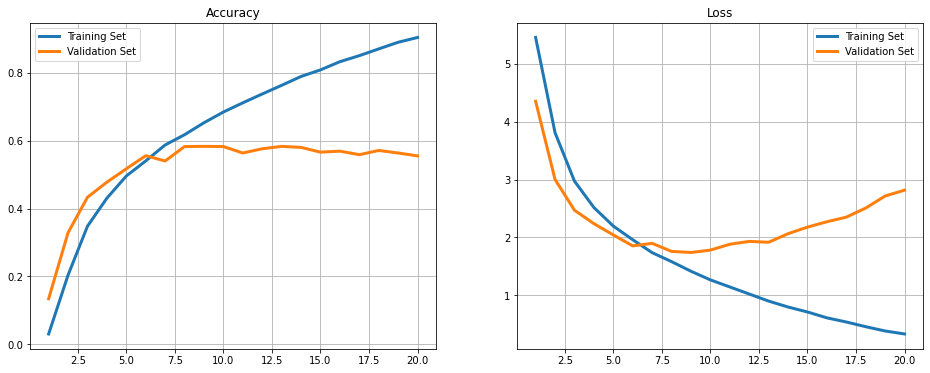

In [63]:
plot_model_training_history(history)

- We see from the above plots that our model is performing fairly well on the validation set, but begins to overfit after the 6th epoch.
- We'll add data augmentation and dropout layers to our model to reduce the amount of overfitting and hopefully increase model accuracy.

In [74]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

model = Sequential([
  layers.Resizing(112, 112, input_shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.25),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20
)

Epoch 1/20
229/229 [==============================] - 28s 121ms/step - loss: 5.5008 - accuracy: 0.0255 - val_loss: 4.6006 - val_accuracy: 0.0890
Epoch 2/20
229/229 [==============================] - 26s 114ms/step - loss: 4.3797 - accuracy: 0.1108 - val_loss: 3.8798 - val_accuracy: 0.1945
Epoch 3/20
229/229 [==============================] - 26s 115ms/step - loss: 3.8365 - accuracy: 0.1862 - val_loss: 3.4069 - val_accuracy: 0.2640
Epoch 4/20
229/229 [==============================] - 27s 115ms/step - loss: 3.4971 - accuracy: 0.2415 - val_loss: 3.0639 - val_accuracy: 0.3305
Epoch 5/20
229/229 [==============================] - 27s 116ms/step - loss: 3.2582 - accuracy: 0.2850 - val_loss: 2.8410 - val_accuracy: 0.3670
Epoch 6/20
229/229 [==============================] - 26s 115ms/step - loss: 3.0741 - accuracy: 0.3192 - val_loss: 2.5956 - val_accuracy: 0.4120
Epoch 7/20
229/229 [==============================] - 26s 113ms/step - loss: 2.9128 - accuracy: 0.3479 - val_loss: 2.4807 - val_ac

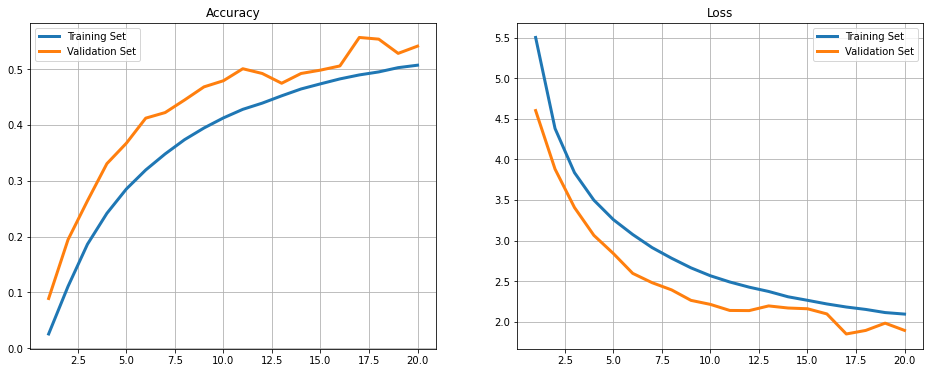

In [70]:
plot_model_training_history(history)

- Even with the augmentation and dropout we seem to be converging on a validation set accuracy of approximately 0.6, albeit at a slower rate.
- We were previously working with a batch size of 256, let's try reducing this.

In [71]:
train_ds, valid_ds, img_height, img_width, num_classes = create_training_and_validation_datasets(X_train, y_train, X_val, y_val, 64)

In [75]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20
)

Epoch 1/20
913/913 [==============================] - 32s 34ms/step - loss: 5.0267 - accuracy: 0.0562 - val_loss: 3.9656 - val_accuracy: 0.1620
Epoch 2/20
913/913 [==============================] - 26s 29ms/step - loss: 3.8087 - accuracy: 0.1942 - val_loss: 3.1038 - val_accuracy: 0.3155
Epoch 3/20
913/913 [==============================] - 27s 29ms/step - loss: 3.1983 - accuracy: 0.2954 - val_loss: 2.6653 - val_accuracy: 0.3875
Epoch 4/20
913/913 [==============================] - 29s 31ms/step - loss: 2.8084 - accuracy: 0.3662 - val_loss: 2.5374 - val_accuracy: 0.4205
Epoch 5/20
913/913 [==============================] - 25s 27ms/step - loss: 2.5639 - accuracy: 0.4144 - val_loss: 2.3038 - val_accuracy: 0.4565
Epoch 6/20
913/913 [==============================] - 25s 28ms/step - loss: 2.4063 - accuracy: 0.4433 - val_loss: 2.0011 - val_accuracy: 0.5285
Epoch 7/20
913/913 [==============================] - 27s 29ms/step - loss: 2.2855 - accuracy: 0.4678 - val_loss: 1.8936 - val_accuracy:

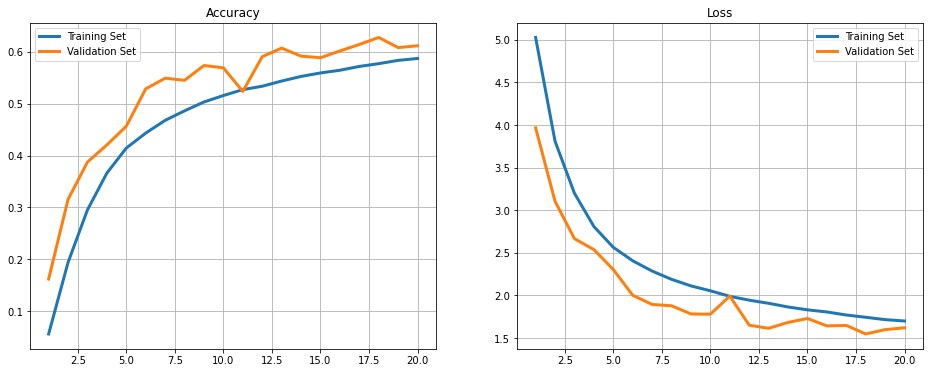

In [77]:
plot_model_training_history(history)

- We have improved our accuracy on the validation set significantly compared to using a larger batch size.
- Let's tweak the architecture of our model.

In [84]:
model = Sequential([
  layers.Resizing(112, 112, input_shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30
)

Epoch 1/30
913/913 [==============================] - 30s 32ms/step - loss: 4.8030 - accuracy: 0.0859 - val_loss: 3.2766 - val_accuracy: 0.2775
Epoch 2/30
913/913 [==============================] - 27s 29ms/step - loss: 3.2415 - accuracy: 0.2939 - val_loss: 2.2755 - val_accuracy: 0.4670
Epoch 3/30
913/913 [==============================] - 29s 32ms/step - loss: 2.5454 - accuracy: 0.4190 - val_loss: 1.7404 - val_accuracy: 0.5770
Epoch 4/30
913/913 [==============================] - 29s 32ms/step - loss: 2.1286 - accuracy: 0.5014 - val_loss: 1.5766 - val_accuracy: 0.6210
Epoch 5/30
913/913 [==============================] - 27s 30ms/step - loss: 1.8865 - accuracy: 0.5508 - val_loss: 1.3866 - val_accuracy: 0.6630
Epoch 6/30
913/913 [==============================] - 31s 33ms/step - loss: 1.7050 - accuracy: 0.5854 - val_loss: 1.3452 - val_accuracy: 0.6705
Epoch 7/30
913/913 [==============================] - 28s 31ms/step - loss: 1.5579 - accuracy: 0.6154 - val_loss: 1.1903 - val_accuracy:

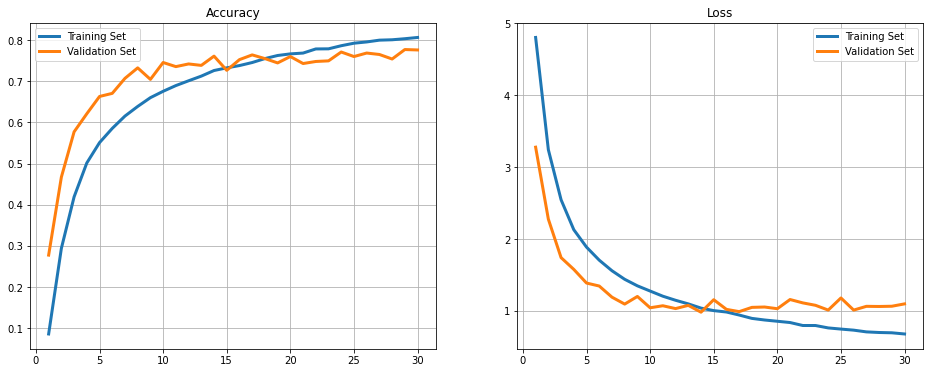

In [86]:
plot_model_training_history(history)

- Excellent, with our new architecture, i.e. more layers, we've increased the accuracy of our network on the validation set considerably
- Let's have a look at the performance of our model on the test set.

Displaying random bird of species EUROPEAN GOLDFINCH


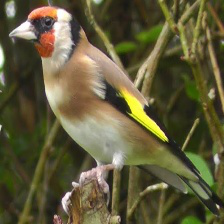

In [163]:
test_image = display_random_image_in_data_set(os.path.join(path_to_data, 'test'))

In [164]:
os.listdir(os.path.join(path_to_data, 'valid'))[model.predict(np.expand_dims(test_image, 0)).argmax()]

'EUROPEAN GOLDFINCH'

In [165]:
X_test, y_test = load_images(os.path.join(path_to_data, 'test'))

Loading Images: 100%|██████████| 400/400 [00:05<00:00, 78.25it/s] 


In [193]:
model_predictions = model.predict(X_test).argmax(axis=1)
print(f"Accuracy score on test set: {metrics.accuracy_score(y_test, model_predictions)}")

Accuracy score on test set: 0.7905


##### Loading and fine-tuning a pretrained model

- Often we can achieve much better accuracy by loading and fine-tuning a pretrained convnet
- We'll load a model from the keras library and fine-tune the bottom layers of the model for our purposes

In [240]:
pretrained_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet')

In [241]:
pretrained_model.trainable = False

In [242]:
model_0 = Sequential(
    [
        layers.Input(shape=(224, 224, 3)),
        pretrained_model,
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(num_classes)
    ]
)

In [ ]:
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [229]:
history = model_0.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10
)

Epoch 1/10
913/913 [==============================] - 275s 287ms/step - loss: 3.8838 - accuracy: 0.6751 - val_loss: 1.6482 - val_accuracy: 0.8635
Epoch 2/10
913/913 [==============================] - 261s 286ms/step - loss: 1.5798 - accuracy: 0.8727 - val_loss: 1.4995 - val_accuracy: 0.8895
Epoch 3/10
913/913 [==============================] - 258s 282ms/step - loss: 1.2110 - accuracy: 0.9075 - val_loss: 1.5216 - val_accuracy: 0.9065
Epoch 4/10
913/913 [==============================] - 259s 283ms/step - loss: 1.0371 - accuracy: 0.9249 - val_loss: 1.6390 - val_accuracy: 0.9105
Epoch 5/10
913/913 [==============================] - 260s 285ms/step - loss: 0.8767 - accuracy: 0.9395 - val_loss: 1.9834 - val_accuracy: 0.9100
Epoch 6/10
913/913 [==============================] - 259s 283ms/step - loss: 0.7814 - accuracy: 0.9481 - val_loss: 1.7640 - val_accuracy: 0.9190
Epoch 7/10
913/913 [==============================] - 260s 285ms/step - loss: 0.7440 - accuracy: 0.9532 - val_loss: 2.0624 -

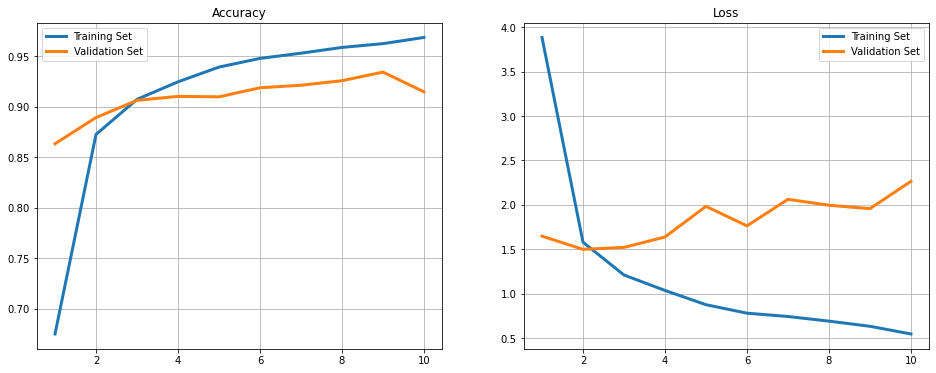

In [230]:
plot_model_training_history(history)